In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

**Data Collecting and Data Cleaning:**

In [2]:
df_org = pd.read_excel('/content/drive/MyDrive/Machine Learning/Datasets/Minor Project Data set (Stock Price Prediction) (1).xlsx')
df = df_org
df.sort_values('Date', inplace=True)

In [3]:
df.index

RangeIndex(start=0, stop=1009, step=1)

In [4]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [5]:
df.shape

(1009, 7)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1009 non-null   datetime64[ns]
 1   Open       1009 non-null   float64       
 2   High       1009 non-null   float64       
 3   Low        1009 non-null   float64       
 4   Close      1009 non-null   float64       
 5   Adj Close  1009 non-null   float64       
 6   Volume     1009 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 55.3 KB


**Handling Missing Data:**

In [7]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

**Data Understanding:**

In [8]:
# Percentage change in daily price.
# How many percent of days does the daily change percent is negative and positive.
df['Daily Price Change Percentage'] = ((df['Close'] - df['Open'])/df['Close']) * 100
cnt1 = 0
cnt2 = 0
cnt3 = 0
for j in range(0, df.shape[0]):
  if(df.iloc[j ,df.shape[1]-1] < 0):
    cnt1 = cnt1 + 1
  elif df.iloc[j , df.shape[1]-1] == 0:
    cnt2 = cnt2 + 1
  else:
    cnt3 = cnt3 + 1

print("Number of days Open value is greater than Close Value: ", cnt1)
print("Number of days Open value is lesser than Close Value: ", cnt3)
print("Number of days Open value is equal to Close Value: ", cnt2)

Number of days Open value is greater than Close Value:  506
Number of days Open value is lesser than Close Value:  502
Number of days Open value is equal to Close Value:  1


In [9]:
# How is average value of the stock related to the closing price.
df['Average Price Value'] = (df['Open'] + df['Close'] + df['Low'] + df['High'])/4
cnt1 = 0
cnt2 = 0
cnt3 = 0
for j in range(0, df.shape[0]):
  # print(df.iloc[j, 4],"------", df.iloc[j, 8])
  if(df.iloc[j, 4] < df.iloc[j, 8]):
    cnt1 = cnt1 + 1
  elif(df.iloc[j, 4] == df.iloc[j, 8]):
    cnt2 = cnt2 + 1
  else:
    cnt3 = cnt3 + 1

print("Number of days where closing price is less than the average of price : ", cnt1)
print("Number of days where closing price is greater than the average of price : ", cnt3)


Number of days where closing price is less than the average of price :  497
Number of days where closing price is greater than the average of price :  512


<Axes: xlabel='month'>

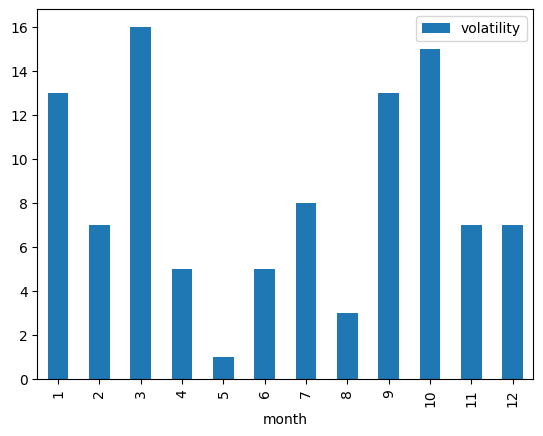

In [10]:
# Months with large volatility or percentage change.
df['volatility'] = df['High'] - df['Low']
df['month'] = df['Date'].dt.month
volatile_days = df.nlargest(100, 'volatility')
volatile = volatile_days.groupby('month')[['volatility']].count()
volatile.plot(kind = 'bar')

In [11]:
# Detecting Abnormal Gaps Between Close and Next Day Open:
df['overnight_return'] = df['Open'].shift(-1) - df['Close']
cnt1 = 0
cnt2 = 0
cnt3 = 0
for i in range(0, df.shape[0]):
  if(df.iloc[i, df.shape[1]-1] > 0):
    cnt1 = cnt1 + 1
  elif(df.iloc[i, df.shape[1]-1] < 0):
    cnt2 = cnt2 + 1
  else:
    cnt3 = cnt3 + 1

print("The opening price of stock is greater than the last closing price : ", cnt1)
print("The opening price of stock is lesser than the last closing price : ", cnt2)
print("The opening price of stock is equal to the last closing price : ", cnt3)

The opening price of stock is greater than the last closing price :  570
The opening price of stock is lesser than the last closing price :  431
The opening price of stock is equal to the last closing price :  8


In [12]:
# Detecting the weekday abnormal gaps between close and next day opening:
df['weekday'] = df['Date'].dt.weekday
weekday_avg = df.groupby('weekday')['volatility'].mean()
weekday_avg

weekday
0    13.458384
1    12.533720
2    13.651853
3    12.770441
4    12.342735
Name: volatility, dtype: float64

In [13]:
df['month'] = df['Date'].dt.month
monthly_avg = df.groupby('month')['volatility'].mean()
monthly_avg

month
1     14.958888
2     12.410257
3     15.050687
4     12.224287
5      9.791072
6     11.043764
7     13.505815
8     10.749430
9     14.332717
10    15.415505
11    13.149510
12    12.707734
Name: volatility, dtype: float64

Total volume traded :  7638821200


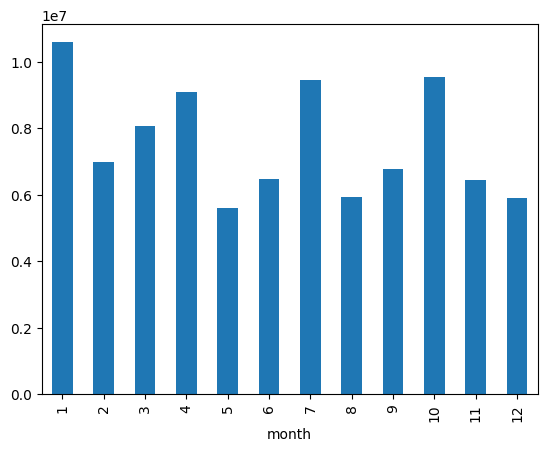

In [14]:
# Monthly average Volume traded
monthly_volume = df.groupby('month')['Volume'].mean()
monthly_volume.plot(kind = 'bar')
# Total volume traded
print("Total volume traded : ", df['Volume'].sum())

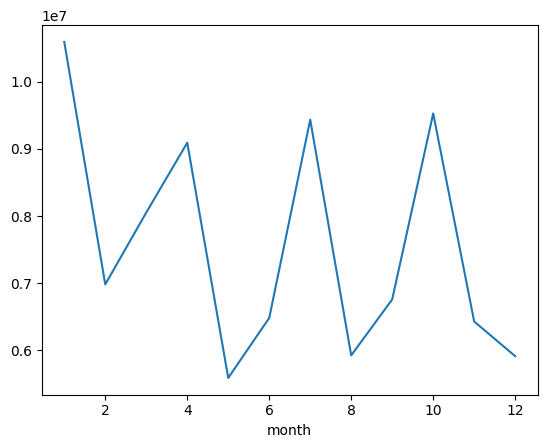

In [15]:
# How are volume traded distributed based on month
monthly_volume = monthly_volume.plot(kind = 'line')

**Using Linear Regression for forecasting and finding accuracy of Close price and Volume**

In [16]:
# Forecasting with Linear Regression
model = LinearRegression()
X = df.index.values.reshape(-1, 1)  # assuming index corresponds to time
y = df['Close'].values
model.fit(X, y)
df['predicted_close'] = model.predict(X)

In [17]:
# Finding the accuracy of Linear Regression Model which predicts close price
mse = mean_squared_error(df['Close'], df['predicted_close'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(df['Close'], df['predicted_close'])
df['mape_close_LR'] = (abs(df['Close'] - df['predicted_close'])/df['Close']) * 100
r2 = r2_score(df['Close'], df['predicted_close'])
print(df['mape_close_LR'].mean())

12.074577916580273


In [18]:
# Predicting Future volume trends using Linear Regression
vol_model = LinearRegression()
vol_X = df.index.values.reshape(-1, 1)  # Assuming index corresponds to time
vol_y = df['Volume'].values
vol_model.fit(vol_X, vol_y)
df['predicted_volume'] = vol_model.predict(vol_X)


In [19]:
# Finding accuracy of predicted values of volume using Linear Regression.
mse = mean_squared_error(df['Volume'], df['predicted_volume'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(df['Volume'], df['predicted_volume'])
df['mape_volume_LR'] = (abs(df['Volume'] - df['predicted_volume'])/df['Volume']) * 100
r2 = r2_score(df['Volume'], df['predicted_volume'])
print(df['mape_volume_LR'].mean())

46.93795962642824


**Using ARIMA for forecasting and finding accuracy of the forecasted values of Close price and Volume**

In [20]:
# Forecasting Close values with ARIMA
model = ARIMA(df['Close'], order=(1, 1, 1))
result = model.fit()
df['forecast_close'] = result.predict(start=0, end=len(df), typ='levels')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [21]:
# Finding accuracy of Predicted values of Close using ARIMA
mse = mean_squared_error(df['Close'], df['forecast_close'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(df['Close'], df['forecast_close'])
df['mape_close_ARIMA'] = (abs(df['Close'] - df['forecast_close'])/df['Close']) * 100
r2 = r2_score(df['Close'], df['forecast_close'])
print(df['mape_close_ARIMA'].mean())

1.9473833857811829


In [22]:
# Finding the future trends of Volume using ARIMA
model = ARIMA(df['Volume'], order=(1, 1, 1))
result = model.fit()
df['forecast_volume'] = result.predict(start=0, end=len(df), typ='levels')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [23]:
# Finding the accuracy of forecasted values of volume using ARIMA
mse = mean_squared_error(df['Volume'], df['forecast_volume'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(df['Volume'], df['forecast_volume'])
df['mape_volume_ARIMA'] = (abs(df['Volume'] - df['forecast_volume'])/df['Volume']) * 100
r2 = r2_score(df['Volume'], df['forecast_volume'])
print(df['mape_volume_ARIMA'].mean())

29.618726800474562


**Using Moving average to forecast and finding accuracy of forecasted Close price and Volume**

In [24]:
# Finding the future trends of Close price using Moving Average
# Calculate the moving average
df['moving_avg_close'] = df['Close'].rolling(window=10).mean()  # 10-day moving average
# Shift the moving average by one day forward for prediction
df['predicted_close_ma'] = df['moving_avg_close'].shift(1)


In [25]:
df.dropna(subset=['predicted_close_ma'], inplace=True)
mse = mean_squared_error(df['Close'], df['predicted_close_ma'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(df['Close'], df['predicted_close_ma'])
df['mape_close_ma'] = (abs(df['Close'] - df['predicted_close_ma'])/df['Close']) * 100
r2 = r2_score(df['Close'], df['predicted_close_ma'])
print(df['mape_close_ma'].mean())

3.6120792531977908


In [26]:
# Finding the future trends of Volume using Moving Average
# Calculate the moving average
df['moving_avg_volume'] = df['Volume'].rolling(window=10).mean()  # 10-day moving average
# Shift the moving average by one day forward for prediction
df['predicted_volume_ma'] = df['moving_avg_volume'].shift(1)

In [27]:
df.dropna(subset=['predicted_volume_ma'], inplace=True)
mse = mean_squared_error(df['Volume'], df['predicted_volume_ma'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(df['Volume'], df['predicted_volume_ma'])
df['mape_volume_ma'] = (abs(df['Volume'] - df['predicted_volume_ma'])/df['Volume']) * 100
r2 = r2_score(df['Volume'], df['predicted_volume_ma'])
print(df['mape_volume_ma'].mean())

36.36428990569825
